## Import necesarry Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

## Exploratory Data Analysis (EDA)

In [2]:
# Load the dataset
df = pd.read_csv('dataset_med.csv')

In [3]:
# View the first few rows
print(df.head())

   id   age  gender      country diagnosis_date cancer_stage family_history  \
0   1  64.0    Male       Sweden     2016-04-05      Stage I            Yes   
1   2  50.0  Female  Netherlands     2023-04-20    Stage III            Yes   
2   3  65.0  Female      Hungary     2023-04-05    Stage III            Yes   
3   4  51.0  Female      Belgium     2016-02-05      Stage I             No   
4   5  37.0    Male   Luxembourg     2023-11-29      Stage I             No   

   smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  \
0  Passive Smoker  29.4                199             0       0          1   
1  Passive Smoker  41.2                280             1       1          0   
2   Former Smoker  44.0                268             1       1          0   
3  Passive Smoker  43.0                241             1       1          0   
4  Passive Smoker  19.7                178             0       0          0   

   other_cancer treatment_type end_treatment_date 

In [4]:
# Check for missing values
print(df.isnull().sum())

id                    0
age                   0
gender                0
country               0
diagnosis_date        0
cancer_stage          0
family_history        0
smoking_status        0
bmi                   0
cholesterol_level     0
hypertension          0
asthma                0
cirrhosis             0
other_cancer          0
treatment_type        0
end_treatment_date    0
survived              0
dtype: int64


In [5]:
# Data types
print(df.dtypes)

id                      int64
age                   float64
gender                 object
country                object
diagnosis_date         object
cancer_stage           object
family_history         object
smoking_status         object
bmi                   float64
cholesterol_level       int64
hypertension            int64
asthma                  int64
cirrhosis               int64
other_cancer            int64
treatment_type         object
end_treatment_date     object
survived                int64
dtype: object


In [6]:
# Summary statistics
print(df.describe())

                  id            age            bmi  cholesterol_level  \
count  890000.000000  890000.000000  890000.000000      890000.000000   
mean   445000.500000      55.007008      30.494172         233.633916   
std    256921.014128       9.994485       8.368539          43.432278   
min         1.000000       4.000000      16.000000         150.000000   
25%    222500.750000      48.000000      23.300000         196.000000   
50%    445000.500000      55.000000      30.500000         242.000000   
75%    667500.250000      62.000000      37.700000         271.000000   
max    890000.000000     104.000000      45.000000         300.000000   

        hypertension         asthma      cirrhosis   other_cancer  \
count  890000.000000  890000.000000  890000.000000  890000.000000   
mean        0.750024       0.469740       0.225956       0.088157   
std         0.432999       0.499084       0.418211       0.283524   
min         0.000000       0.000000       0.000000       0.000000 

## Feature Engineering

In [7]:
# Encoding categorical variables
label_encoders = {}
categorical_columns = ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 
                       'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type', 'survived']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
# Ordinal encoding
df['gender'] = pd.Categorical(df['gender']).codes
df['cancer_stage'] = pd.Categorical(df['cancer_stage']).codes
df['smoking_status'] = pd.Categorical(df['smoking_status']).codes
df['treatment_type'] = pd.Categorical(df['treatment_type']).codes

In [9]:
# One-hot encoding
country_dummies = pd.get_dummies(df['country'])
df = pd.concat([df, country_dummies], axis=1)
df.drop('country', axis=1, inplace=True)

In [10]:
# Date features
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])
df['time_since_diagnosis'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days

In [11]:
# Scaling
scaler = StandardScaler()
df[['bmi', 'cholesterol_level']] = scaler.fit_transform(df[['bmi', 'cholesterol_level']])

## Feature Selection

In [12]:
# Convert datetime columns to numerical representations
df['diagnosis_year'] = df['diagnosis_date'].dt.year
df['diagnosis_month'] = df['diagnosis_date'].dt.month
df['diagnosis_day'] = df['diagnosis_date'].dt.day

df['end_treatment_year'] = df['end_treatment_date'].dt.year
df['end_treatment_month'] = df['end_treatment_date'].dt.month
df['end_treatment_day'] = df['end_treatment_date'].dt.day

# Drop original datetime columns
df.drop(['diagnosis_date', 'end_treatment_date'], axis=1, inplace=True)

In [13]:
# Mutual information
# provides a statistical measure of the relationship between a feature and the target variable.
mi = mutual_info_classif(df.drop('survived', axis=1), df['survived'])
mi_features = df.drop('survived', axis=1).columns[mi.argsort()[-10:]]

In [14]:
selected_df = df[mi_features.tolist() + ['survived']]

In [16]:
print("Selected Features:", mi_features)

Selected Features: Index(['diagnosis_year', 'diagnosis_month', 'end_treatment_month', 'asthma',
       'cancer_stage', 'treatment_type', 'smoking_status', 'family_history',
       'gender', 'hypertension'],
      dtype='object')


## Modelling

In [18]:
df.columns = df.columns.astype(str)


In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df[mi_features], df['survived'], test_size=0.2, random_state=42)

In [20]:
# Train model
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Evaluate model
y_pred = rfc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7247696629213484
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84    138639
           1       0.22      0.10      0.13     39361

    accuracy                           0.72    178000
   macro avg       0.50      0.50      0.49    178000
weighted avg       0.66      0.72      0.68    178000

Confusion Matrix:
[[125218  13421]
 [ 35570   3791]]


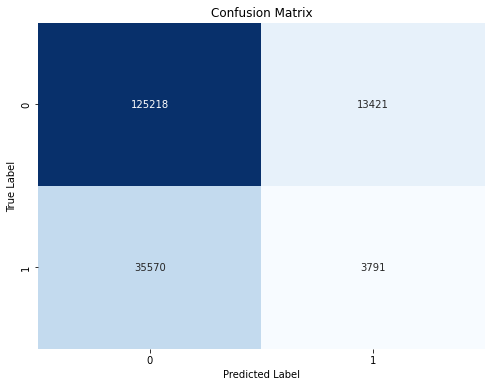

In [23]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Predictions

In [24]:
# Make predictions
y_pred = rfc.predict(X_test)

In [25]:
# Evaluate predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7247696629213484
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84    138639
           1       0.22      0.10      0.13     39361

    accuracy                           0.72    178000
   macro avg       0.50      0.50      0.49    178000
weighted avg       0.66      0.72      0.68    178000

Confusion Matrix:
[[125218  13421]
 [ 35570   3791]]


In [26]:
# View predictions
print("Predictions:")
print(y_pred)

Predictions:
[0 0 1 ... 0 0 0]


In [27]:
# Compare predictions with actual values
print("\nPrediction Comparison:")
print("Predicted\tActual")
for i in range(len(y_pred)):
    print(f"{y_pred[i]}\t\t{y_test.values[i]}")


Prediction Comparison:
Predicted	Actual
0		0
0		0
1		1
0		1
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
1		0
1		1
0		0
1		1
0		0
0		0
0		0
0		1
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		0
0		1
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		1
0		0
0		1
0		0
0		1
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		1
0		1
0		1
1		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
1		0
0		1
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		0
1		0
0		0
0		1
0		0
0		0
0		0
0		0
0		1
1		0
0		0
1		0
0		0
0		0
1		1
0		0
0		1
0		0
0		0
0		0
0		0
0		1
0		1
0		0
0		0
0		0
0		1
1		0
0		1
0		0
0		0
0		1
0		1
0		0
0		0
1		0
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		1
0		0
0		1
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		1
0		0
0		1
0		0
1		0
0		0
0		0
0		0
0		0
0		0
0		0
0		0
0		1
0		0
0		0
0		1
0		0
0		0